In [1]:
from dynamics_modeling.utils import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots as _

## Monthly Interpolation

In [2]:
# Hourly weather data
pga_df = load_mesonet("dynamics_modeling/PGA_2005_2020.csv")
# Hourly solar data
irr_df = load_pvgis("dynamics_modeling/curve_radiation_2005_2020.csv")

# Averaged monthly pan evaporation rate (https://wrcc.dri.edu/Climate/comp_table_show.php?stype=pan_evap_avg)
pan_m_df = pd.DataFrame(
    {
        "month": list(range(1, 13)),
        "evap": [
            2.45,  # Interpolated (originally 0.00)
            2.60,
            5.84,
            8.27,
            10.72,
            12.86,
            13.06,
            11.38,
            8.42,
            5.13,
            2.29,
            2.45,  # Interpolated (originally 0.00)
        ],
    }
)

# Pan rate (in/month) -> Reservoir rate (mm/day) (assuming 30 days/month)
pan_m_df["est"] = 0.8 * pan_m_df["evap"] * 25.4 / 30

FileNotFoundError: [Errno 2] No such file or directory: 'dynamics_modeling/PGA_2005_2020.csv'

In [ ]:
# Monthly weather and solar data
pga_m_df = get_mean(pga_df, "valid", ["tmpc", "dwpc", "smps"], "M")
irr_m_df = get_mean(irr_df, "time", ["G(i)"], "M")

# Monthly reservoir data: weather and solar
res_m_df = pd.merge(
    pga_m_df,
    irr_m_df["G(i)"],
    how="inner",
    left_on="valid",
    right_on="time",
    suffixes=["_res", "_irr"],
)

# Estimate monthly evaporation using
res_m_df["est"] = res_m_df.apply(
    lambda row: get_evaporation_rate(
        row["tmpc"], row["dwpc"], 1815, row["G(i)"], row["smps"]
    ),
    axis=1,
)

# Averaged monthly evaporation
res_m_mean_df = res_m_df["est"].groupby(res_m_df["month"]).mean()

In [ ]:
# Averaged monthly reservoir data
res_m_data = (
    res_m_df.groupby("month").mean()[["tmpc", "dwpc", "G(i)", "smps"]].to_numpy()
)

pan_m_evap = pan_m_df.evap.to_numpy()
popt = get_fit_parameters(res_m_data, pan_m_evap)

plt.xlabel("Month (0-11)")
plt.ylabel("Evaporation Rate (mm/day)")
plt.plot(pan_m_df["evap"].to_numpy(), "o")  # Pan estimations
plt.plot(res_m_mean_df.to_numpy(), "o")  # Model predictions
plt.plot(
    pan_m_df["month"].to_numpy() - 1,
    evaporation_rate_curve(res_m_data, *popt),
    "b",
)
plt.plot()

## Daily Interpolation

In [ ]:
# Daily weather and solar data
pga_d_df = get_mean(pga_df, "valid", ["tmpc", "dwpc", "smps", "p01i"], "D")
irr_d_df = get_mean(irr_df, "time", ["G(i)"], "D")

# Monthly reservoir data: weather and solar
res_d_df = pd.merge(
    pga_d_df,
    irr_d_df["G(i)"],
    how="inner",
    left_on="valid",
    right_on="time",
    suffixes=["_res", "_irr"],
)

# Estimate average daily evaporation
d_evap = evaporation_rate_curve(
    res_d_df.groupby(["month", "day"])
    .mean()[["tmpc", "dwpc", "G(i)", "smps"]]
    .to_numpy(),
    *popt
)
# Average daily precipitation
d_precip = (
    get_sum(pga_df, "valid", ["p01i"], "D")
    .groupby(["month", "day"])
    .mean()["p01i"]
    .to_numpy()
)

NameError: name 'irr_df' is not defined

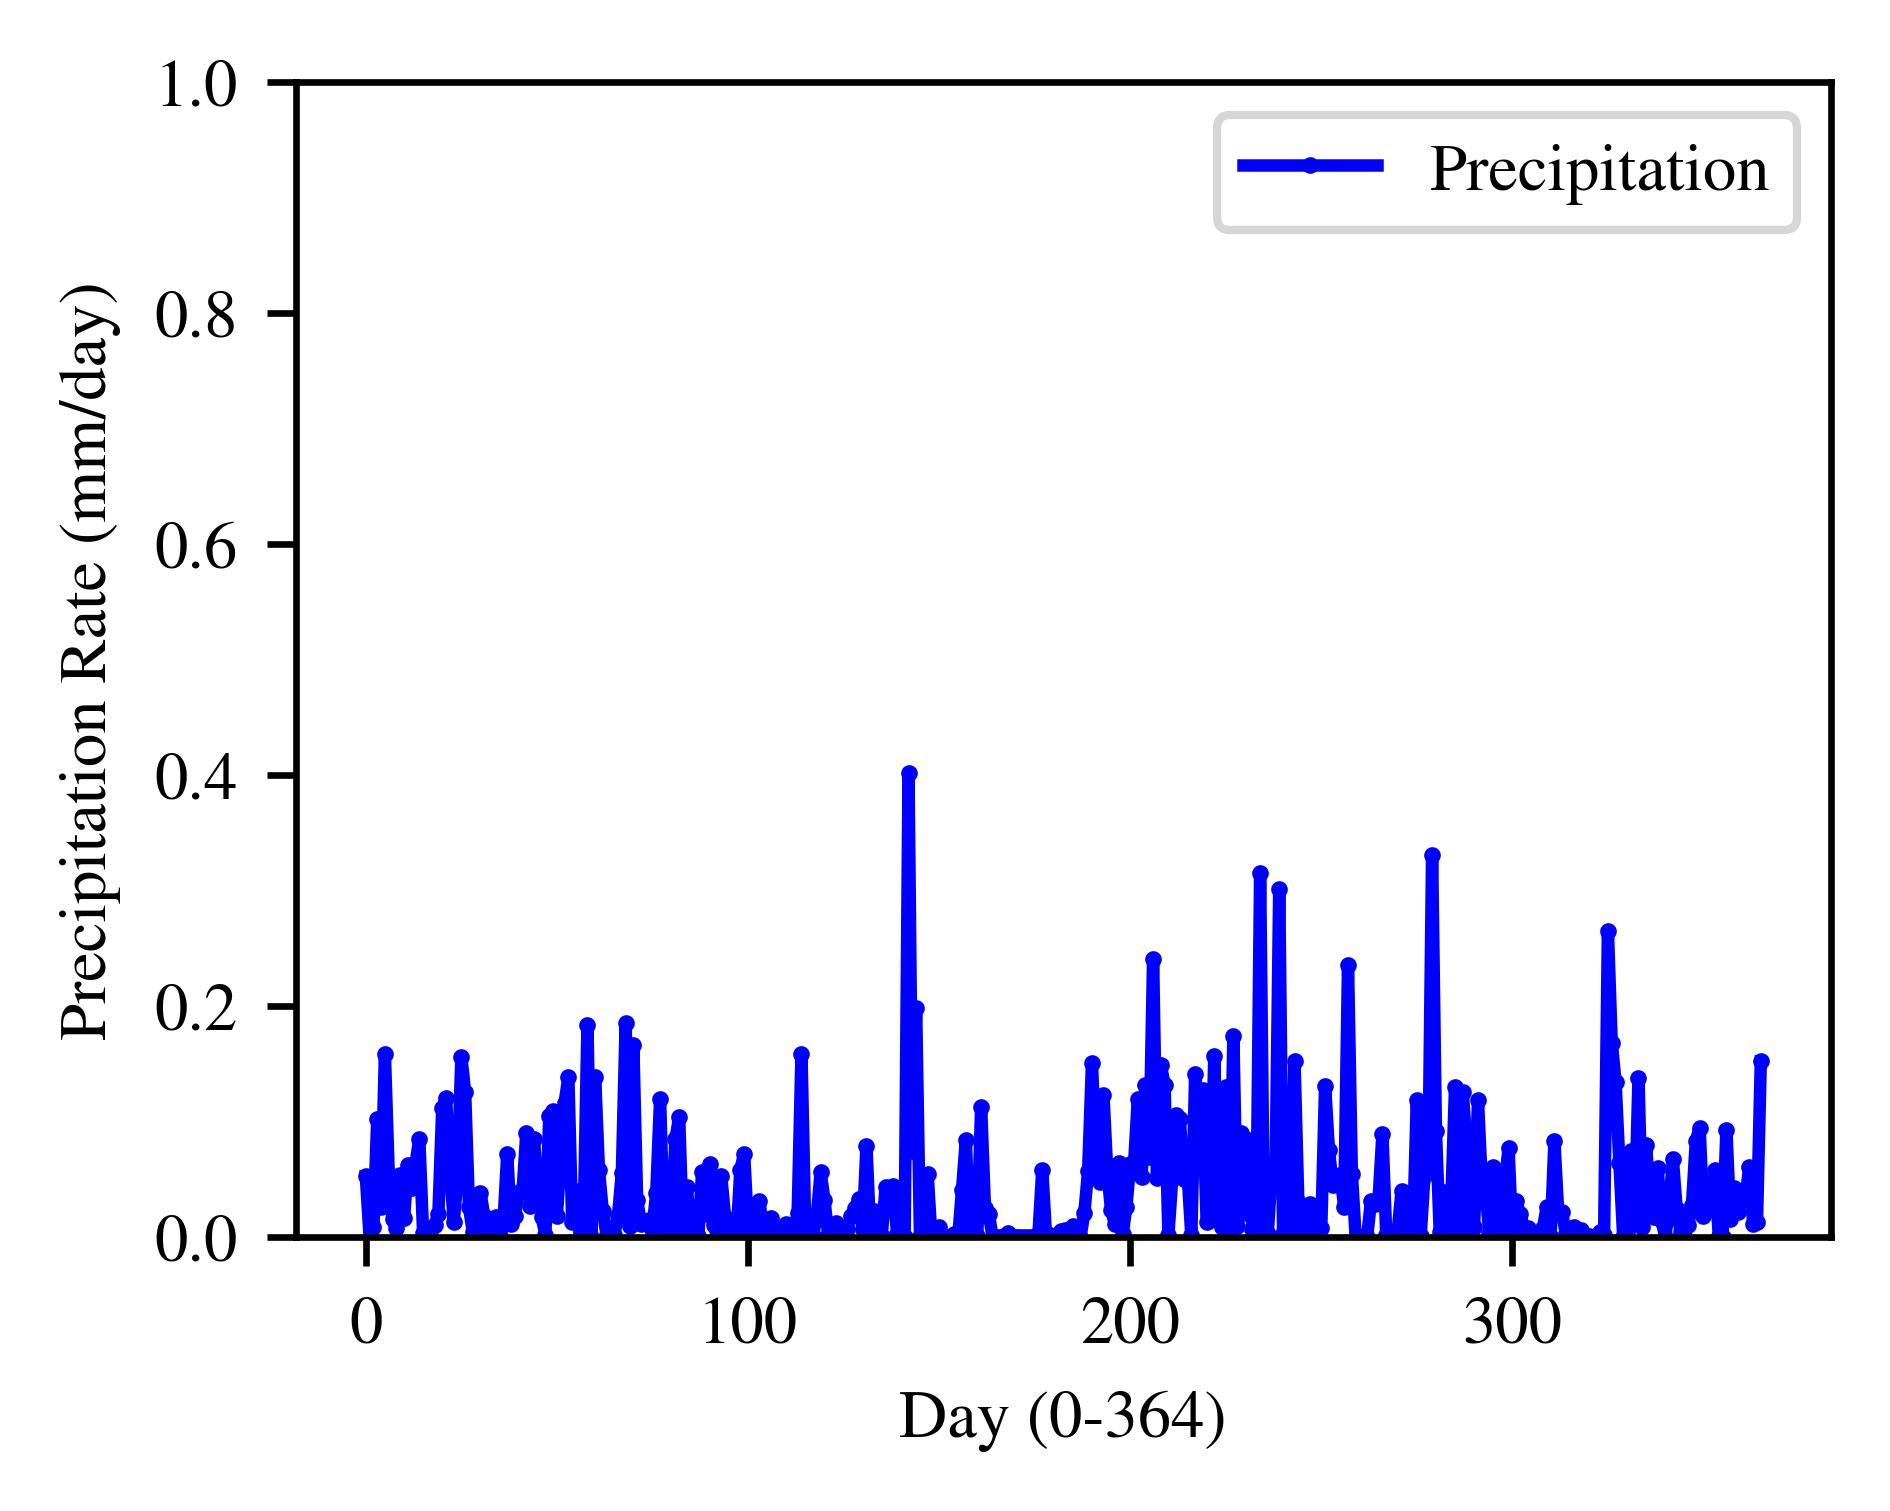

In [ ]:
# d_evap[d_evap < 0] = 0
# d_precip[d_precip < 0] = 0

plt.figure()
plt.xlabel("Day (0-364)")
plt.ylabel("Precipitation Rate (mm/day)")
# plt.plot(d_evap, "-ro", label="Evaporation", markersize=1)  # Model predictions
plt.plot(d_precip, "-bo", label="Precipitation", markersize=1)  # Precipitation
plt.ylim(0, 1)
plt.legend()